This notebook is adapted from the Tensorflow
research notebook
[hosted on colab](https://colab.research.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb#scrollTo=nyHoF4mUrv5-)
and
[shared (r) at github](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb)

This notebook adds to the tutorial an option for android lawn statue images and tests on a YouTube video.

The model configuration used by the original duckies tutorial is a TPU trained model.
Other pretrained models to explore and more information:

*   https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#tensorflow-object-detection-api-installation
*   https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/object_detection_camera.html#sphx-glr-auto-examples-object-detection-camera-py
*   https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_training_and_evaluation.md


# Eager Few Shot Object Detection Colab

Welcome to the Eager Few Shot Object Detection Colab --- in this colab we demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint.
Training runs in eager mode.

Estimated time to run through this colab (with GPU): < 5 minutes.

## Imports

In [ ]:
#!pip install -U --pre tensorflow=="2.2.0"

## Choose dataname by uncommenting one of the following:

In [ ]:
'''
duckies:
   this is adapted from the original tensorflow notebook (referenced above)

statues:
   training data:  7 images, containing a mix of 8 android mascots
   test data:  a short YouTube video of mavy android mascots

gingerbread_man:
   training data:  3 images containing the gingerbread man mascot
   test data:  2 images containing the gingerbread man mascot

gingerbread_man_2:
   training data:  5 images containing the gingerbread man mascot
   test data:  a short YouTube video of mavy android mascots
'''
#dataname = "duckies"
dataname = "statues"
#dataname = "gingerbread_man"
#dataname = "gingerbread_man_2"


In [ ]:
import os
import pathlib
import math

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
#
# if you are running a notebook in an environment missing protoc through protobuf,
# there are several ways to install protoc. one is to download a binary and put
# it in your path (add that binary path to $PATH in .bash_profile or other shell init file)
# https://github.com/protocolbuffers/protobuf/releases
# if you're installing on macos, you may need to follow these directions to give the app permission to run
# https://support.apple.com/guide/mac-help/apple-cant-check-app-for-malicious-software-mchleab3a043/mac
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

FIGSIZE = (8, 6)
THRESH = 0.5

# Utilities

In [ ]:
def load_image_into_numpy_array(path : str):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np : np.array,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=FIGSIZE, thresh=THRESH,
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  #print(f'classes={classes}')
  #print(f'category_index={category_index}')
  #print(f'image_np.shape={image_np.shape}')
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=25,
      min_score_thresh=THRESH)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)
    # consider import google.colab.patches import cv2_imshow


# Load Rubber Ducky or android statues or gingerbread man data

We will start with some toy (literally) data consisting of 5 images of a rubber
ducky.  Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain rubber duckies (or even ducks for that matter), so this is a novel class.

In [ ]:
# Load images and visualize
train_images_np = []
test_images_np = [] #this will be empty for video tests

if dataname == "duckies" :
    train_image_dir = 'models/research/object_detection/test_images/ducky/train/'
    for i in range(1, 6):
        image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
        train_images_np.append(load_image_into_numpy_array(image_path))

    num_classes = 1
    duck_class_id = 0
    class_mapping = {duck_class_id:'rubber_ducky'}
    category_index = {i: {'id':i, 'name':cls}
                      for i, cls in class_mapping.items()}
    gt_boxes = [
              np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
              np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
              np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
              np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
              np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
    ]
    class_ids = [[duck_class_id], [duck_class_id], [duck_class_id], [duck_class_id], [duck_class_id]]

    class_ids_test = []
    gt_boxes_test = [] #empty as we don't have bounding boxes.
    test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
    for i in range(1, 50):
        image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
        #test_images_np.append(np.expand_dims(
        #  load_image_into_numpy_array(image_path), axis=0))
        test_images_np.append(load_image_into_numpy_array(image_path))
        class_ids_test.append([duck_class_id])

else:
    #statues or gingerbread_man or gingerbread_man_2

    # define bounding boxes and load images

    # gt_boxes.shape=(batch, num_classes_in_image, 4)
    #  [1,6,4]
    #  [1,4,4]
    #  [1,4,4]
    #  [1,6,4]
    #  [1,2,4]
    #  [1,3,4]
    #  [1,2,4]
    '''
    android statues 01 is from:
    https://www.flickr.com/photos/67287915@N00/8570385915
    android statues 02 is from:
    https://www.flickr.com/photos/quinnanya/5847206255
    android statues 03 and 04 are from:
    https://github.com/nking/curvature-scale-space-corners-and-transformations.git
    android statues 05 is from:
    https://commons.wikimedia.org/wiki/File:IceCream_Sandwich_%287791561448%29.jpg
    android statues 06 is from:
    https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Sculpture_for_Android_Donut_at_Google_Mountain_View.jpg/320px-Sculpture_for_Android_Donut_at_Google_Mountain_View.jpg
    android statues 07 is from:
    https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/Android_Jelly_Bean_Lawn_Statue_%2812757851595%29.jpg/320px-Android_Jelly_Bean_Lawn_Statue_%2812757851595%29.jpg

                      ytop    xleft   ybottom  xright    w    h
      android 1 (tr)   w=640  h=279
    0 cupcake          134,     18,      191,      70,
    1 euclair          176,    101,      244,     229,
    2 icecream         129,    125,      188,     175,
    3 gingerbread_man  122,    212,      193,     262,
    4 icecream_sandwich 101,   280,      213,     365,
    5 honey_comb        128,   391,      190,     455,

      android 2 (tr)   w=640, h=427
    0 cupcake          125,   128,        213,    212
    1 euclair          186,   61,         358,    207,
    2 icecream         105,  274,         233,    376
    3 gingerbread_man  59,   493,         272,    594

      android 3 (te)  w=1280, h=960
    1 euclair          396,   278,       467,     497,
    3 gingerbread_man  234,    57,       525,     303,
    4 icecream_sandwich 227,  501,       494,     740,
            (obscured)
    5 honeycomb        279,   702,       447,     788,
    6 kitkat           228,   494,       590,     714,
    7 jellybean        255,   932,       477,    1046,

      android 4 (tr) w=1280, h=960
    0 cupcake          309,   311,       615,    605,
    1 euclair          456,   998,       507,   1131,
    2 icecream         329,   671,       575,    848,
    3 gingerbread_man  318,   875,       552,   1041,

      android 5 (te)  w=450, h=600
    3 gingerbread_man  210,   107,       413,   177,
    4 icecream_sandwich 161,   152,      507,   480,

      android 6 (tr)  w=320,  h=181
    0 cupcake           33,     0,       121,    41,
    6 kitkat            44,   239,        97,   261,
    8 donut             0,      58,      180,   244,

      android 7 (tr)  w=320,  h=213
    7 jellybean        15,    151,       197,    274,
    8 donut            64,     80,       110,    112,
                      ytop    xleft   ybottom  xright
    '''

    def make_bb(ytop, xleft, ybottom, xright, w, h) :
        return [ytop/h, xleft/w, ybottom/h, xright/w]

    class_mapping = {0:'cupcake', 1:'euclair', 2:'icecream', 3:'gingerbread_man',
                     4:'icecream_sandwich', 5:'honey_comb', 6:'kitkat',
                     7:'jellybean', 8:'donut'}

    class_ids_01 = [0, 1, 2, 3, 4, 5]
    bb_01 = [make_bb(134,     18,      191,      70, 640, 279),
            make_bb(176,    101,      244,     229, 640, 279),
            make_bb(129,    125,      188,     175, 640, 279),
             make_bb(122,    212,      193,     262, 640, 279),
             make_bb(101,   280,      213,     365, 640, 279),
             make_bb(128,   391,      190,     455, 640, 279),
    ]

    class_ids_02 = [0, 1, 2, 3]
    bb_02 = [make_bb(125,   128,        213,    212, 640, 427),
            make_bb(186,   61,         358,    207, 640, 427),
             make_bb(105,  274,         233,    376, 640, 427),
             make_bb(59,   493,         272,    594, 640, 427),
    ]

    class_ids_03 = [1, 3, 4, 5, 6, 7]
    bb_03 = [make_bb(396,   278,       467,     497, 1280, 960),
            make_bb(234,    57,       525,     303, 1280, 960),
             make_bb(227,  501,       494,     740, 1280, 960),
             make_bb(279,   702,       447,     788, 1280, 960),
             make_bb(228,   494,       590,     714, 1280, 960),
             make_bb(255,   932,       477,    1046, 1280, 960),
    ]

    class_ids_04 = [0,1,2,3]
    bb_04 = [make_bb(309,   311,       615,    605, 1280, 960),
            make_bb(456,   998,       507,   1131, 1280, 960),
             make_bb(329,   671,       575,    848, 1280, 960),
             make_bb(318,   875,       552,   1041, 1280, 960),
    ]

    class_ids_05 = [3, 4]
    bb_05 = [make_bb(210,   107,       413,   177, 450, 600),
            make_bb(161,   152,      507,   480, 450, 600),
    ]

    class_ids_06 = [0, 6, 8]
    bb_06 = [make_bb(33,     0,       121,    41, 320, 181),
             make_bb(44,   239,        97,   261, 320, 181),
             make_bb(0,      58,      180,   244, 320, 181)
    ]

    class_ids_07 = [7, 8]
    bb_07 = [make_bb(15,    151,       197,    274, 320, 213),
             make_bb(64,     80,       110,    112, 320, 213)
    ]

    import tempfile
    from tempfile import TemporaryDirectory

    remote_url = "https://raw.githubusercontent.com/nking/curvature-scale-space-corners-and-transformations/master/testresources/"

    data_dir = tempfile.mkdtemp()
    print(f'temp_dataset_dir={data_dir}')

    # download and store images
    for i in range(1, 8):
        file_name = 'android_statues_0' + str(i) + '.jpg'
        req_url = remote_url + file_name
        !wget {req_url} -P {data_dir}
        image_path = os.path.join(data_dir, file_name)
        # statues train is all images, 1 - 7
        # gingerbread_man train is images 1,2,4, test is 3,5
        # gingerbread_man_2 train is images 1-5
        if dataname == "statues":
            train_images_np.append(load_image_into_numpy_array(image_path))
        elif dataname == "gingerbread_man":
            if i == 1 or i == 2 or i == 4:
                train_images_np.append(load_image_into_numpy_array(image_path))
            elif i == 3 or i == 5:
                test_images_np.append(load_image_into_numpy_array(image_path))
        elif dataname == "gingerbread_man_2":
            if i < 6:
                train_images_np.append(load_image_into_numpy_array(image_path))

    if dataname == "statues":
        gt_boxes = [
                np.array(bb_01, dtype=np.float32),
                np.array(bb_02, dtype=np.float32),
                np.array(bb_03, dtype=np.float32),
                np.array(bb_04, dtype=np.float32),
                np.array(bb_05, dtype=np.float32),
                np.array(bb_06, dtype=np.float32),
                np.array(bb_07, dtype=np.float32)
        ]
        class_ids = [class_ids_01, class_ids_02, class_ids_03, class_ids_04,
                     class_ids_05, class_ids_06, class_ids_07]
        category_index = {i: {'id':i, 'name':cls}
                      for i, cls in class_mapping.items()}
        # test is video
    elif dataname == "gingerbread_man_2":
        gt_boxes = [
                np.array([bb_01[3]], dtype=np.float32),
                np.array([bb_02[3]], dtype=np.float32),
                np.array([bb_03[3]], dtype=np.float32),
                np.array([bb_04[3]], dtype=np.float32),
                np.array([bb_05[3]], dtype=np.float32),
        ]
        class_ids = [[0], [0], [0], [0], [0]]
        category_index = {0: {'id': 0, 'name': 'gingerbread_man'}}
        # test is video
    elif dataname == "gingerbread_man":
        # gingerbread_man
        gt_boxes = [
                np.array([bb_01[3]], dtype=np.float32),
                np.array([bb_02[3]], dtype=np.float32),
                np.array([bb_04[3]], dtype=np.float32),
        ]
        class_ids = [[0], [0], [0]]
        gt_boxes_test = [
                np.array([bb_03[1]], dtype=np.float32),
                np.array([bb_05[0]], dtype=np.float32),
        ]
        class_ids_test = [[0], [0]]
        category_index = {0: {'id': 0, 'name': 'gingerbread_man'}}

    num_classes = len(category_index)

print(f'num_classes={num_classes}')
print(f'category_index={category_index}')
print(f'len(gt_boxes)={len(gt_boxes)}')
print(f'class_ids={class_ids}')

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [FIGSIZE[0], FIGSIZE[1]]


# Annotate images with bounding boxes

In this cell you will annotate the rubber duckies --- draw a box around the rubber ducky in each image; click `next image` to go to the next image and `submit` when there are no more images.

If you'd like to skip the manual annotation step, we totally understand.  In this case, simply skip this cell and run the next cell instead, where we've prepopulated the groundtruth with pre-annotated bounding boxes.



In [ ]:
# nice tool, but can only label one object per image
#gt_boxes = []
#colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

# In case you didn't want to label...

Run this cell only if you didn't annotate anything above and
would prefer to just use our preannotated boxes.  Don't forget
to uncomment.

In [ ]:
# moved this to a higher cell and skipped the interactive labelling
# gt_boxes = [
#             np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
#             np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
#             np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
#             np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
#             np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
# ]

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [ ]:


# Convert class labels to one-hot; convert everything to tensors.
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for idx, train_image_np in enumerate(train_images_np):
  gt_box_np = gt_boxes[idx]
  n = gt_box_np.shape[0]
  box_label_idxs = class_ids[idx] #TODO check on this
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))

  #print(f'{n} labeled boxes.  num_classes={num_classes}')
  print(f'gt_box_tensors={gt_box_tensors}')

  #zero_indexed_groundtruth_classes = tf.convert_to_tensor(
  #   np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  cls_arr = np.array(box_label_idxs, dtype=np.int32)
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(cls_arr)
  #print(f'zero_indexed_groundtruth_classes={zero_indexed_groundtruth_classes}')

  one_hot_per_box_tensor = tf.one_hot(
      indices=zero_indexed_groundtruth_classes, depth=num_classes)
  gt_classes_one_hot_tensors.append(one_hot_per_box_tensor)

  print(f'gt_classes_one_hot_tensors={gt_classes_one_hot_tensors}')

print('Done prepping data.')

# Let's just visualize the rubber duckies (or statues) as a sanity check


In [ ]:
nt = len(train_images_np)
ncols = 3
nrows = int(math.ceil(nt/ncols))
plt_h = int(nrows * FIGSIZE[1]/2)
fig = plt.figure(figsize=(FIGSIZE[0], plt_h))

for idx in range(nt):
    n = gt_boxes[idx].shape[0]

    fake_pred_classes = np.array(class_ids[idx])
    fake_pred_scores = np.ones(shape=[n], dtype=np.float32)  # give boxes a score of 100%

    print(f'[{idx}] box labels = {fake_pred_classes}')
    print(f'   scores={fake_pred_scores}')
    print(f'gt_boxes[{idx}]={gt_boxes[idx]}')

    ax = plt.subplot(nrows, ncols, idx+1)
    ax.set_title('train ' + str(idx))
    plot_detections(train_images_np[idx], gt_boxes[idx],
        fake_pred_classes, fake_pred_scores, category_index)

has_test_bounding_boxes = False
try:
  has_test_bounding_boxes = len(gt_boxes_test) == len(test_images_np)
except NameError:
  pass

if has_test_bounding_boxes:
    nt = len(test_images_np)
    ncols = 3
    nrows = int(math.ceil(nt/ncols))
    for idx in range(len(test_images_np)):
        n = gt_boxes_test[idx].shape[0]

        fake_pred_classes = np.array(class_ids_test[idx])
        fake_pred_scores = np.ones(shape=[n], dtype=np.float32)  # give boxes a score of 100%

        #print(f'[{idx}] box labels = {fake_pred_classes}')
        #print(f'   scores={fake_pred_scores}')
        #print(f'gt_boxes_test[{idx}]={gt_boxes_test[idx]}')

        ax = plt.subplot(nrows, ncols, idx+1)
        ax.set_title('test ' + str(idx))
        plot_detections(test_images_np[idx], gt_boxes_test[idx],
            fake_pred_classes, fake_pred_scores, category_index)
else :
    # a peek at subset of test images. will do noting for empty test array
    j = 1
    nt = len(test_images_np)
    ncols = 3
    nrows = int(math.ceil((nt/10.)/ncols))
    for idx in range(0, nt, 10):
        ax = plt.subplot(nrows, ncols, j)
        ax.set_title('test ' + str(idx))
        plt.imshow(test_images_np[idx])
        j += 1


# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

#TODO: consider pretrained SSD models trained on architecture runnable on desktop
#   https://pytorch.org/hub/nvidia_deeplearningexamples_ssd/ if not jetson...
#   https://docs.nvidia.com/metropolis/TLT/tlt-user-guide/text/object_detection/ssd.html
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

#consider checking for existence of models/research/object_detection/test_data/checkpoint
# if not pathlib.Path('checkpoint').exists():
## however, the download is less than 10 sec on collab.

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/


In [ ]:
tf.keras.backend.clear_session()

#https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/object_detection_camera.html#sphx-glr-auto-examples-object-detection-camera-py

print('Building model and restoring weights for fine-tuning...', flush=True)
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Lists the checkpoint keys and shapes of variables in a checkpoint.
# Returns: List of tuples (key, shape).
#cp_list = tf.compat.v2.train.list_variables(checkpoint_path)
#for cp_key, cp_shape in cp_list:
#    print(f'checkpoint key={cp_key}')

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
'''
config key=model
config key=train_config
config key=train_input_config
config key=eval_config
config key=eval_input_configs
config key=eval_input_config
'''

'''
configs[model] = ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    #FPN is Feature Pyramid Network.  FPN constructions uses features maps starting from fpn_min_levelupto the fpn_max_level.
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: false
      negatives_lower_than_unmatched: true
      force_match_for_each_row: true
      use_matmul_gather: true
    }
  }
  similarity_calculator {
    iou_similarity {
    }
  }
  box_predictor {
    weight_shared_convolutional_box_predictor {
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 0.00039999998989515007
          }
        }
        initializer {
          random_normal_initializer {
            mean: 0.0
            stddev: 0.009999999776482582
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.996999979019165
          scale: true
          epsilon: 0.0010000000474974513
        }
      }
      depth: 256
      num_layers_before_predictor: 4
      kernel_size: 3
      class_prediction_bias_init: -4.599999904632568
    }
  }
  anchor_generator {
    multiscale_anchor_generator {
      min_level: 3
      max_level: 7
      anchor_scale: 4.0
      aspect_ratios: 1.0
      aspect_ratios: 2.0
      aspect_ratios: 0.5
      scales_per_octave: 2
    }
  }
  post_processing {
    batch_non_max_suppression {
      score_threshold: 9.99999993922529e-09
      iou_threshold: 0.6000000238418579
      max_detections_per_class: 100
      max_total_detections: 100
    }
    score_converter: SIGMOID
  }
  normalize_loss_by_num_matches: true
  loss {
    localization_loss {
      weighted_smooth_l1 {
      }
    }
    classification_loss {
      # sigmoid for multi-label classification
      weighted_sigmoid_focal {
        gamma: 2.0
        alpha: 0.25
      }
    }
    classification_weight: 1.0
    localization_weight: 1.0
  }
  encode_background_as_zeros: true
  normalize_loc_loss_by_codesize: true
  inplace_batchnorm_update: true
  freeze_batchnorm: false
}
'''
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True

#TODO: deprecated, so update to use createModel (Context context, String modelPath, Model.Options options)
detection_model = model_builder.build(model_config=model_config, is_training=True)

trainable_variables = detection_model.trainable_variables
for i in range(len(trainable_variables) // 2):
    print(f'trainable variable[{i}] = {trainable_variables[i]}')
    #trainable_variables[i].trainable = False

# Set up object-based checkpoint restore
# RetinaNet has two prediction `heads`
# --- one for classification,
# --- the other for box regression.
# We will restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # to restore the classification weights requires us to use
    #    configs['model'].ssd.num_classes = 90 to match the checkpoint
    #    else uncommenting the next line leads to ValueError from shape in WeightSharedConvolutionalClassHead
    #_prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., _prediction_heads includes the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )

# fake_model loads the pre-trained weights.  the feature extractor is used by our classification training
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor = detection_model._feature_extractor,
          _box_predictor     = fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
#    arg is a rank 4 image tensor: [1, height, width, channels]
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
# implies we are using batch_size=1; argument features shape is[batch_size, height, width, channels]

#print(f'fake shapes from preprocess: \n   {shapes}') #[[640 640   3]]

prediction_dict = detection_model.predict(image, shapes)

#print(f'fake prediction from predict: \n   {prediction_dict}')
# {'preprocessed_inputs'
#'feature_maps'
#'anchors'
#'final_anchors'
#'box_encodings'
#'class_predictions_with_background'

#class_predictions_with_background: A float tensor of shape
#        [batch_size, 1, num_class_slots] representing the class predictions for
#        the proposals.

_ = detection_model.postprocess(prediction_dict, shapes)

#print(f'fake postprocess = {_}')
#fake postprocess = {'detection_boxes'
#'detection_scores' # a tensor of shape=(1, 100).  for 100 coco classes I think.  follow up on this
#'detection_classes': <tf.Tensor: shape=(1, 100)  these are all '2.'
#'num_detections'
#'raw_detection_scores'
#'detection_multiclass_scores' <tf.Tensor: shape=(1, 100, 9).num_classes=8
#'detection_anchor_indices'

print('Weights restored!')

# Eager mode custom training loop



In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
if dataname == "duckies" :
  batch_size = 4
  learning_rate = 0.01
  num_batches = 100
elif dataname == "statues":
  batch_size = len(train_images_np)
  learning_rate = 0.01
  num_batches = 100
  '''
  check that increasing the regularization increases the loss.
  with learning_rate = 0.01
  batch 10 of 100, loss=1.1345885
  batch 20 of 100, loss=0.4580749
  batch 30 of 100, loss=0.48080766
  batch 40 of 100, loss=0.09977268
  batch 50 of 100, loss=0.02614792
  batch 60 of 100, loss=0.115248576
  batch 70 of 100, loss=0.11414003
  batch 80 of 100, loss=0.07316341
  batch 90 of 100, loss=0.043971308

  compare to learning_rate = 0.001 (which should take longer and have smaller loss)
  (but, is in context of over-fitting...)
  '''
else:
  batch_size = len(train_images_np)
  learning_rate = 0.01
  num_batches = 100
  '''
  w/ learning_rate=0.001:
  batch 0 of 100, loss=1.256472
  batch 10 of 100, loss=0.40674606
  batch 20 of 100, loss=0.13199718
  batch 30 of 100, loss=0.06470875
  batch 40 of 100, loss=0.046196118
  batch 50 of 100, loss=0.03695421
  batch 60 of 100, loss=0.031888764
  batch 70 of 100, loss=0.028527014
  batch 80 of 100, loss=0.026031561
  batch 90 of 100, loss=0.024059335
  '''

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # https://www.tensorflow.org/guide/function
  # eager execution is turned on by default
  # tf.function makes graphs out of your programs. It is a transformation tool
  # that creates Python-independent dataflow graphs out of your Python code.
  # This will help you create performant and portable models, and it is required
  # to use SavedModel
  # Debug in eager mode, then decorate with @tf.function.
  # tf.functions can be faster than eager code, especially for graphs with many
  # small ops.

  # Comment out the tf.function decorator (annotation) if you want the inside of the
  # function to run eagerly (without autograph optimizations).
  @tf.function(reduce_retracing=True)
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)

    #print(f'groundtruth_boxes_list={groundtruth_boxes_list}')
    #print(f'groundtruth_classes_list={groundtruth_classes_list}')
    #print(f'shapes={shapes}')
    #print(f'shapes.shape={shapes.shape}')
    #print(f'groundtruth_boxes_list len,shape={len(groundtruth_boxes_list)}, {groundtruth_boxes_list[0].shape}')
    #print(f'groundtruth_classes_list len,shape={len(groundtruth_classes_list)}, {groundtruth_classes_list[0].shape}')

    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      #print(f'preprocessed_images.shape={preprocessed_images.shape}')
      #keys of prediction_dict (['preprocessed_inputs', 'feature_maps', 'anchors',
      # 'final_anchors', 'box_encodings', 'class_predictions_with_background'])
      prediction_dict = model.predict(preprocessed_images, shapes)
      #breakpoint()
      losses_dict = model.loss(prediction_dict, shapes)
      #print(f'losses_dict.keys={losses_dict.keys()}')
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
#optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate,
#                                     beta_1=0.9, beta_2=0.999)

train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples.  these are indexes of the array train_images_np
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size] # this is indices to array train_images_np

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  # note: there may be tensorflow warnings abut excessive tracing for using
  # method get_model_train_step_function.
  # "A graph may not be reusable for inputs with a different signature (shape and dtype),
  # a new graph is generated instead."  so, added reduce_retracing=True to the
  # tf.function decorator/annotation.

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

In [ ]:
# define mapping and loss functions for use while exploring the test detections

def intersection_over_union(gt : list, pred : list):
    '''
    calculate the intersection over union for the 2 given bounding boxes.

    uses the code from
    https://pyimagesearch.com/2022/05/02/mean-average-precision-map-using-the-coco-evaluator/

    Args:
        gt (list) : the ground truth bounding box coordinates
        pred (list) : the detectected bounding box coordinates
    Returns:
    '''
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(gt[0], pred[0])
    yA = max(gt[1], pred[1])
    xB = min(gt[2], pred[2])
    yB = min(gt[3], pred[3])
    # if there is no overlap between predicted and ground-truth box
    if xB < xA or yB < yA:
        return 0.0
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
    boxBArea = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def calc_matched_indexes(gt_b : list, detected_b : list) :
    '''
    match the bounding boxes using IOU and a min-cost unbalanced bipartite
    matching.

    The bipartite algorithm used is one within Google ortools.
    https://developers.google.com/optimization/assignment/assignment_example

    for the cost matrix, the 1.-iou is used.

    Args:
       gt_b (list) : list of ground truth bounding boxes.  each bounding box is
          a list of floating point values of length 4
       detected_b (list) : list of detected bounding boxes

    Returns: a dictionary with key = index of groundtruth list and value = matching
    index of detected list.
    '''

    swap = (len(gt_b) < len(detected_b))
    print(f'swap={swap}')
    if swap:
        tmp = gt_b
        gt_b = detected_b
        detected_b = tmp

    m = len(gt_b)       # workers
    n = len(detected_b) # tasks
    # m rows, n cols
    costs = [[0. for j in range(n)] for i in range(m)]
    # costs need to be integers.  max_iou=1 => 1-1=0 so best scores are very small numbers.  min_iou=0 => 1
    # (1-0.99) should be resolvable as an integer so will use fctr >= 100
    fctr = 1000.
    for i in range(m):
      for j in range(n):
        iou_i_j = intersection_over_union(gt_b[i], detected_b[j])
        costs[i][j] = round(fctr*(1. - iou_i_j))

    solver = pywraplp.Solver.CreateSolver("SCIP")

    if not solver:
        print(f'no solver found')
        exit()

    num_workers = m
    num_tasks = n

    # Variables
    # x[i, j] is an array of 0-1 variables, which will be 1
    # if worker i is assigned to task j.
    x = {}
    for i in range(num_workers):
        for j in range(num_tasks):
            x[i, j] = solver.IntVar(0, 1, "")

    # Constraints
    # Each worker is assigned to at most 1 task.
    for i in range(num_workers):
        solver.Add(solver.Sum([x[i, j] for j in range(num_tasks)]) <= 1)

    # Each task is assigned to exactly one worker.
    for j in range(num_tasks):
        solver.Add(solver.Sum([x[i, j] for i in range(num_workers)]) == 1)

    # Objective
    objective_terms = []
    for i in range(num_workers):
        for j in range(num_tasks):
            objective_terms.append(costs[i][j] * x[i, j])
    solver.Minimize(solver.Sum(objective_terms))

    # Solve
    status = solver.Solve()

    # Print solution.
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        print(f"Total cost = {solver.Objective().Value()}\n")
        matched = {}
        for i in range(num_workers):
            for j in range(num_tasks):
                # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
                if x[i, j].solution_value() > 0.5:
                    if swap:
                        matched[j] = i
                        print(f"Worker {j} assigned to task {i}." + f" Cost: {costs[i][j]}")
                    else:
                        matched[i] = j
                        print(f"Worker {i} assigned to task {j}." + f" Cost: {costs[i][j]}")
        return matched
    else:
        print("No solution found.")
        return None

def classification_loss(matched_idxs : dict, gt_class_ids : list,
                        detection_class_ids : list, detection_scores : list):
    '''
    for use if want to calculate the classification losses based up the
    bipartite unbalanced weighted matching by bounding boxes.  Not completely
    consistent to use this method because we use the detection scores and not what
    went into making them.
    '''
    # MCCE: -sum_over_k_classes(y_k * log(p_k))
    # where y_k is the indicator function.  it is 1 when y_pred matches y_true, else is 0.
    # the p_k are the scores from the predictions.  they have already been
    # converted to probabilities using softmax and so from_logits=False in use
    # of tensorflow's SparseCategoricalCrossEntropy.

    loss = 1E-7
    for idx1, idx2 in matched_idxs.items():
      c1 = gt_class_ids[idx1]
      c2 = detection_class_ids[idx2]
      loss += -1.*math.log(c2*c1)
    loss /= (len(matched_idxs))
    return loss

# if wanted to do the mAP analysis:
# use a range of thresholds of iou to decide about the class labeling:
# thresh 0.5 to 0.95 with d=0.05.
#   - calc confusion matrix
#   - calc precision and recall
#   - calc area under precision recall curve
#      use iou as PR_AUC = integral from 0 to 1 of precision(rev) * d(rec)
#   - measure the average precision for each class, AP_i
# - mAP = (1/N) * sum over i (AP_i) where N is the number of classes

'''
Got this error from installing ortools, but the protobuf version conflict did
not prevent use of the solver:

ERROR: pip's dependency resolver does not currently take into account all the
packages that are installed. This behaviour is the source of the following
dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3,
but you have protobuf 4.25.0 which is incompatible.
apache-beam 2.51.0 requires protobuf!=4.0.*,!=4.21.*,!=4.22.0,!=4.23.*,!=4.24.0,!=4.24.1,!=4.24.2,<4.25.0,>=3.20.3,
but you have protobuf 4.25.0 which is incompatible.
'''
!pip install ortools
import ortools
from ortools.linear_solver import pywraplp

def calc_losses(gt_b : list, gt_class_ids: list, detected_b : list,
                detected_class_ids : list, detected_scores : list) :
    '''
    given the ground truth bounding boxes and the detected bounding boxes,
    and their respective classification indexes,
    find the best matches and
    return the matched indexes, ious as localication loss, classification loss.
    TODO: consider adding mAP too.

    Note: It is not completely consistent to use this method because we use the
    detection scores and not what went into making them.

    Args:
       gt_b (list) : list of ground truth bounding boxes.  each bounding box is
          a list of floating point values of length 4
       gt_class_ids (list) : list of ground truth class ids
       detected_b (list) : list of detected bounding boxes
       detected_class_ids (list) : list of detected class ids
       detection_scores (list) : list of detected scores for the bounding boxes and class ids.

    Returns: a dictionary with keys 'localization_loss', 'classification_loss'
    '''

    matched_idxs = calc_matched_indexes(gt_b, detected_b)

    if matched_idxs is None:
      return None

    classification_loss = classification_loss(matched_idxs, gt_class_ids,
                        detected_class_ids, detected_scores)

    localization_loss = 0.
    for idx1, idx2 in matched_idxs.items():
      iou = intersection_over_union(gt_b[idx1], detected_b[idx2])
      localization_loss += (1. - iou)

    localization_loss /= (len(matched_idxs))

    return {'localization_loss': localization_loss, 'classification_loss': classification_loss}



# Load any test video and run inference with new model!

In [ ]:
# @title

# @tf.function is used to tell TensorFlow that a function should be compiled
# into a graph that can be executed by TensorFlow's optimized runtime

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor : tf.Tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  # model.predict returns Numpy array(s) of predictions.
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  detections = detection_model.postprocess(prediction_dict, shapes)
  return detections, prediction_dict

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

if dataname == "duckies":
    # there are 50, so plot only 7
    for i in range(0, len(test_images_np), 7):

        input_tensor = tf.convert_to_tensor(np.expand_dims(test_images_np[i], axis=0), dtype=tf.float32)
        detections, prediction_dict = detect(input_tensor)

        #print(f"detections['detection_boxes']={detections['detection_boxes']}")
        #print(f"detections['detection_classes']={detections['detection_classes']}")
        #print(f"detections['detection_scores']={detections['detection_scores']}")

        print(f'({i}) next plot_detections')
        plot_detections(
            test_images_np[i],
            detections['detection_boxes'][0].numpy(),
            detections['detection_classes'][0].numpy().astype(np.uint32),
            detections['detection_scores'][0].numpy(),
            category_index, figsize=FIGSIZE, thresh=THRESH
            #, image_name="gif_frame_" + ('%02d' % i) + ".jpg"
            )

elif dataname == "gingerbread_man":
    for i in range(len(test_images_np)):
        input_tensor = tf.convert_to_tensor(np.expand_dims(test_images_np[i], axis=0), dtype=tf.float32)
        detections, prediction_dict = detect(input_tensor)

        print(f"detections['detection_boxes']={detections['detection_boxes']}")
        print(f"detections['detection_classes']={detections['detection_classes']}")
        print(f"detections['detection_scores']={detections['detection_scores']}")

        bb = gt_boxes_test[i].tolist()
        labels = class_ids_test[i]
        pred = detections['detection_boxes'][0].numpy().tolist()
        plot_detections(
            test_images_np[i],
            detections['detection_boxes'][0].numpy(),
            detections['detection_classes'][0].numpy().astype(np.uint32),
            detections['detection_scores'][0].numpy(),
            category_index, figsize=FIGSIZE, thresh=THRESH)
        # find matching bounding boxes
        #breakpoint()
        matched_idxs = calc_matched_indexes(bb, pred)
        print(f'matched_idxs={matched_idxs}')
else:
    #android statues video as test
    # video title: "Google HQ Android Statues"
    # creator: Polsky Morillo
    video_url = "https://www.youtube.com/watch?v=BRKLw_16Lac"

    !pip install opencv-python
    !pip install --upgrade yt-dlp
    !apt -y install ffmpeg lame

    import imutils
    import cv2

    def get_frame(time, frame_count, filepath) :
        vid_cap.set(cv2.CAP_PROP_POS_MSEC, time)
        # youtube frame rate options: 24 to 60 frames/sec
        frame_det, frame = vid_cap.read()
        print(f'read correctly={frame_det}')
        if frame_det:
            frame = imutils.resize(frame, width=640) #smaller width of 128?
            print(f'writing to {filepath}')
            return cv2.imwrite(filepath, frame) #return True if written
        else:
            return None

    stream_uri = os.path.join(data_dir, "android_statues.mp4")

    #https://pypi.org/project/yt-dlp/
    #Video Format Options
    # --check-formats

    #!yt-dlp $video_url --list-formats
    '''
    [info] Available formats for BRKLw_16Lac:
    ID  EXT   RESOLUTION FPS CH │   FILESIZE  TBR PROTO │ VCODEC         VBR ACODEC      ABR ASR MORE INFO
    ────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    sb3 mhtml 48x27        3    │                 mhtml │ images                                 storyboard
    sb2 mhtml 79x45        1    │                 mhtml │ images                                 storyboard
    sb1 mhtml 159x90       1    │                 mhtml │ images                                 storyboard
    sb0 mhtml 319x180      1    │                 mhtml │ images                                 storyboard
    233 mp4   audio only        │                 m3u8  │ audio only         unknown             Default
    234 mp4   audio only        │                 m3u8  │ audio only         unknown             Default
    599 m4a   audio only      2 │  110.08KiB  31k https │ audio only         mp4a.40.5   31k 22k ultralow, m4a_dash
    600 webm  audio only      2 │   13.08KiB   4k https │ audio only         opus         4k 48k ultralow, webm_dash
    139 m4a   audio only      2 │  174.06KiB  49k https │ audio only         mp4a.40.5   49k 22k low, m4a_dash
    249 webm  audio only      2 │   13.08KiB   4k https │ audio only         opus         4k 48k low, webm_dash
    250 webm  audio only      2 │   13.08KiB   4k https │ audio only         opus         4k 48k low, webm_dash
    140 m4a   audio only      2 │  459.75KiB 130k https │ audio only         mp4a.40.2  130k 44k medium, m4a_dash
    251 webm  audio only      2 │   13.08KiB   4k https │ audio only         opus         4k 48k medium, webm_dash
    17  3gp   176x144      7  1 │  248.81KiB  70k https │ mp4v.20.3          mp4a.40.2       22k 144p
    597 mp4   256x144     15    │  113.67KiB  32k https │ avc1.4d400b    32k video only          144p, mp4_dash
    602 mp4   256x144     15    │ ~375.83KiB 104k m3u8  │ vp09.00.10.08 104k video only
    598 webm  256x144     15    │  141.00KiB  40k https │ vp9            40k video only          144p, webm_dash
    269 mp4   256x144     30    │ ~617.65KiB 170k m3u8  │ avc1.4D400C   170k video only
    160 mp4   256x144     30    │  393.15KiB 111k https │ avc1.4D400C   111k video only          144p, mp4_dash
    603 mp4   256x144     30    │ ~668.17KiB 184k m3u8  │ vp09.00.11.08 184k video only
    278 webm  256x144     30    │  362.32KiB 103k https │ vp09.00.11.08 103k video only          144p, webm_dash
    229 mp4   426x240     30    │ ~  1.13MiB 318k m3u8  │ avc1.4D4015   318k video only
    133 mp4   426x240     30    │  871.24KiB 247k https │ avc1.4D4015   247k video only          240p, mp4_dash
    604 mp4   426x240     30    │ ~  1.23MiB 347k m3u8  │ vp09.00.20.08 347k video only
    242 webm  426x240     30    │  803.84KiB 228k https │ vp09.00.20.08 228k video only          240p, webm_dash
    230 mp4   638x360     30    │ ~  2.83MiB 800k m3u8  │ avc1.4D401E   800k video only
    134 mp4   638x360     30    │    2.18MiB 631k https │ avc1.4D401E   631k video only          360p, mp4_dash
    18  mp4   638x360     30  2 │    2.55MiB 735k https │ avc1.42001E        mp4a.40.2       44k 360p
    605 mp4   638x360     30    │ ~  2.37MiB 668k m3u8  │ vp09.00.21.08 668k video only
    243 webm  638x360     30    │    1.47MiB 426k https │ vp09.00.21.08 426k video only          360p, webm_dash
    '''

    if (not os.path.exists(stream_uri)):
        print(f'downloading youtube file')
        # default is ffmpeg,  can choose mp4 with -f
        !yt-dlp $video_url -vU -f mp4 -o $stream_uri
        '''
        [youtube] Extracting URL: https://www.youtube.com/watch?v=BRKLw_16Lac
        [youtube] BRKLw_16Lac: Downloading webpage
        [youtube] BRKLw_16Lac: Downloading ios player API JSON
        [youtube] BRKLw_16Lac: Downloading android player API JSON
        [youtube] BRKLw_16Lac: Downloading m3u8 information
        ERROR: [youtube] BRKLw_16Lac: Requested format is not available.
            Use --list-formats for a list of available formats
        ...
        [debug] Sort order given by extractor: quality, res, fps, hdr:12, source, vcodec:vp9.2, channels, acodec, lang, proto
        [debug] Formats sorted by: hasvid, ie_pref, quality, res, fps, hdr:12(7), source, vcodec:vp9.2(10), channels, acodec, lang, proto, size, br, asr, vext, aext, hasaud, id
        [info] BRKLw_16Lac: Downloading 1 format(s): 18
        [debug] Invoking http downloader on "https://rr2---sn-npoldn7s.googlevideo.com/videoplayback?expire=1700180177&ei=cVxWZb78DIOZ3LUPq7WkIA&ip=34.124.190.55&id=o-ABYYepNgKahbwzodzQLY1cI5jo4X2FgV_7-a4v57a-2k&itag=18&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&mh=-v&mm=31%2C26&mn=sn-npoldn7s%2Csn-a5m7lnl6&ms=au%2Conr&mv=m&mvi=2&pl=23&initcwndbps=5193750&spc=UWF9f8kgIgBkhETrsm2hHAQAVuedUjg&vprv=1&svpuc=1&mime=video%2Fmp4&gir=yes&clen=2669045&ratebypass=yes&dur=29.048&lmt=1694608020841733&mt=1700157908&fvip=4&fexp=24007246&beids=24350018&c=ANDROID&txp=5318224&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cxpc%2Cspc%2Cvprv%2Csvpuc%2Cmime%2Cgir%2Cclen%2Cratebypass%2Cdur%2Clmt&sig=ANLwegAwRgIhAMAqjIs-alzT8ZigFN1dr-txOKvx54pQ93O3f2h0X-d-AiEAquZ2bo8ZKdBYRtyUYOJlmRozRkF1WZPREMBT3gIDy5k%3D&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpl%2Cinitcwndbps&lsig=AM8Gb2swRQIgVn2fb2Xc4YPnMR9JpFyQ84cHuGtLFXT9AvwsOQcYgdICIQCWxhVd3Sc9iRaR4zkRYwr-dFiy0IOAXRBC9BpyoPB2Ng%3D%3D"
        [download] Destination: /tmp/tmphwbs6im8/android_statues.mp4
        [download] 100% of    2.55MiB in 00:00:01 at 1.44MiB/s
        '''
    else:
        print(f'have already downloaded YouTube mp4 file')

    # the video is 35 sec long
    vid_cap = cv2.VideoCapture(stream_uri)
    if not vid_cap.isOpened():
        print(f'video capture is not opened yet.  try now:')
        vid_cap.open(video_url)
    print(f'vid_cap.isOpened()={vid_cap.isOpened()}')

    #vid_cap.set(cv2.CV_CAP_PROP_FRAME_WIDTH, 640)

    fps = vid_cap.get(cv2.CAP_PROP_FPS)
    print(f'fps={fps}')
    print(f'CAP_PROP_FRAME_COUNT={vid_cap.get(cv2.CAP_PROP_FRAME_COUNT)}')
    num_frames = int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if (fps > 0):
        end_time = int(num_frames/fps)*1000
    else:
        end_time = 35*1000
    print(f'end_time={end_time}')

    pred_all = []
    scores_all = []

    start_time = 0
    frame_rate = 2000 #in millisec = 2 sec
    frame_count = 1
    for time in range(start_time, end_time, frame_rate):
        time = round(time, 2)
        filepath = os.path.join(data_dir, str(frame_count) + '.jpg')
        result = get_frame(time, frame_count, filepath)
        frame_count += 1
        if result is not None:
            img = load_image_into_numpy_array(filepath)
            input_tensor = tf.convert_to_tensor(np.expand_dims(img, axis=0), dtype=tf.float32)
            detections, prediction_dict = detect(input_tensor)
            dc = detections['detection_classes'][0].numpy().astype(np.uint32)
            ds = detections['detection_scores'][0].numpy()
            plot_detections(
                img,
                detections['detection_boxes'][0].numpy(),
                dc, ds,
                category_index, figsize=(15, 20), thresh=THRESH
                #, image_name=filepath
                )
            plt.show()
            # useful for making confusion matrix, prec, recall, mAP, etc:
            p = []
            s = []
            for ii in range(len(ds)):
                if ds[ii] >= THRESH:
                    p.append(dc[ii])
                    s.append(ds[ii])
            print(f"pred_{frame_count-1}={p}")
            print(f"score_{frame_count-1}=",["{0:0.2f}".format(ii) for ii in s])
            pred_all.extend(p)
            scores_all.extend(s)
        else:
            print(f'get_frame failed')

    vid_cap.release()
    cv2.destroyAllWindows()

    print(f'the id to class mapping={class_mapping}')
    print(f"pred_all= {pred_all}")
    print("scores_all=",["{0:0.2f}".format(ii) for ii in scores_all])

plt.show() #plt.show() should be called only once per python session
print('done')

# **Misc Notes**

---
Variations tried for android lawn statues:
*   (1) For a train set being android statues 01, 02, and 04, and a test set being android statues 03 and 05:
There were 100 detections for each of the test images.
The train set includes classes 0 through 5, inclusive, but not 6 or 7.  The detector did not report any classes as 6 or 7, as expected because those were not in the train set.
> android statues 03 test had 3 scores above 0.5.  Of those with scores >= 0.5, only the bounding box for detection[1] matched the expected bounding box and classification.  To look at details further, I used an unbalanced weighted bipartite matching for the bounding boxes where the cost was 1-iou between 2 boxes.  IOU is intersection over union a.k.a. Jaccard index.  The matches by IOU showed matched_idxs={1: 1, 5: 14, 0: 21, 2: 22, 4: 45, 3: 66} which correspond to classes 3:3, 7:5, 1:1, ... The 3rd match is correct too, but has score 0.117.
> android statues 05 test.  Looks like non-max supression failed for the first 2 detection
bounding boxes.  predicted 1st class correctly, but with wrong bounding box.
>   * If I truly wanted to keep the training set this small, then a way to improve the detections might be to
reduce the number of classes as that would improve the scores for the expected detections.  e.g. Could reduce the classes to gingerbread man only, as the duckies example does.  (In progress...)
> Increasing the training set number of images and using a video to test, that is, put all my old train and test images into train, and then use a short video from YouTube to test.  (done, can see this now when dataname == "statues")

*   (2) For a train set being android statues 01, 02, 03, 04, and 05, and a test set being several frames from a short YouTube video of the android statues:
> The detector sometimes identified non-statue objects in the image as statues, such as a truck or a bench.
> * We are currently using transfer learning as a pre-trained model built from ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config.
We use the feature extractor and bounding box detector from the pretrained model and re-train for  classification (which uses feature extractor).
To identify the non-android statue objects we could use the object detector without retraining (it identifies COCO class objects).  We note those
identifications and scores.
And then identify android statues with our re-trained model.  The identified android statue bounding boxes can be compared to the identified COCO bounding boxes and one chosen over the other.
(note: COCO has 80 classes (640x480).
PascalVOC has 20 classes ().
imagenet1K has 1000 classes (~470x~390).
open-image has 600 classes.)
> * I added train image(s) for the android donut, lolli-pop and jelly-bean to improve the training.

*   (3) For a train set being android statues 01, 02, 03, 04, 05, 06, and 07 and a test set being several frames from a short YouTube video of the android statues:
> precision, recall, f1 score and accuracy were calculated as a function of score threshold and a threshold of 0.5 was found to result in a macro averaged precision, recall, f1 score and accuracy > 0.72.  For that reason, THRESH above has been set to 0.5 now.
Here are the statistics derived from THRESH 0.2 to 1.0, which can also be found [here](https://github.com/nking/curvature-scale-space-corners-and-transformations/raw/master/doc/statues_transfer_learning_object_detection.pdf)

class id    class name    #of images w/ class in it
0 cupcake :              4
1 euclair:               4
2 icecream:              3
3 gingerbread_man:       5
4 icecream_sandwich:     3
5 honeycomb:             2
6 kitkat:                2
7 jellybean:             2
8 donut:                 2

14 test frames were taken from a YouTube video.

ground_truth_labels_all=[3, 9, 2, 2, 3, 9, 5, 2, 2, 2, 2, 2, 3, 2, 8, 8, 2, 8, 8, 3, 8, 9, 9, 3, 6, 3, 5, 8, 9, 8, 0, 0, 9, 4, 9, 9, 9, 9, 8, 0, 0, 4, 0, 4, 4, 9, 9, 0, 9, 0, 9, 0, 3, 0, 3, 7, 1, 6, 9, 1, 9, 6]

pred_all= [3, 7, 0, 0, 3, 7, 5, 1, 0, 2, 0, 2, 3, 1, 8, 8, 2, 1, 8, 3, 1, 4, 7, 5, 4, 3, 5, 8, 7, 1, 0, 0, 0, 7, 0, 0, 7, 0, 0, 7, 7, 7, 0, 8, 7, 5, 0, 0, 7, 0, 4, 7, 3, 7, 8, 2, 1, 7, 1, 1, 7, 6]

scores_all= ['0.29', '0.25', '0.55', '0.45', '0.39', '0.33', '0.32', '0.32', '0.30', '0.29', ‘0.25', '0.25', '0.53', '0.38', '0.29', '0.62', '0.32', '0.31', '0.66', '0.45', '0.43', '0.29', '0.28', '0.27', '0.32', '0.63', '0.47', '0.44', '0.42', '0.32', '0.29', '0.28', '0.26', '0.52', '0.48', '0.45', '0.37', '0.33', '0.30', '0.28', '0.28', '0.44', '0.34', '0.39', '0.36', '0.35', '0.33', '0.31', '0.31', '0.28', '0.27', '0.27', '0.61', '0.48', '0.35', '0.28', '0.35', '0.28', '0.50', '0.47', '0.38', '0.35']

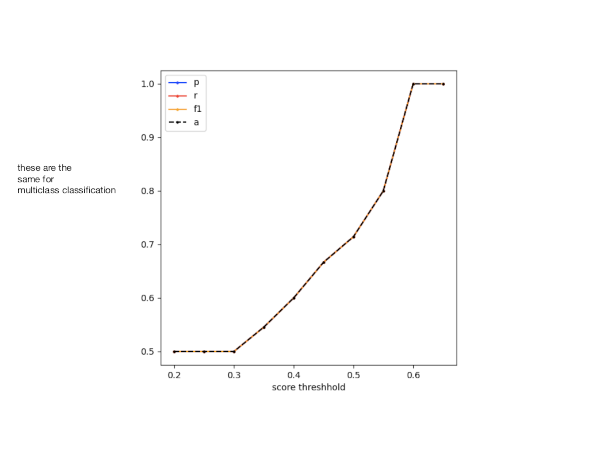
---